In [3]:
# import utility libraries
from netCDF4 import Dataset
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap, cm
%matplotlib inline

# import machine learning tools
from sklearn.preprocessing import StandardScaler
# import theano
# theano.config.device = 'gpu'
# theano.config.floatX = 'float32'
from keras.models import Sequential, Graph
from keras.layers import Dense, Flatten, Activation, Dropout
from keras.layers.convolutional import Convolution2D, ZeroPadding2D, MaxPooling2D
from keras.optimizers import SGD
from keras import backend as K

from clustering import Location_Clusterer, plot_list_in_2D

Using Theano backend.


In [4]:
n = 8

/home/ubuntu/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


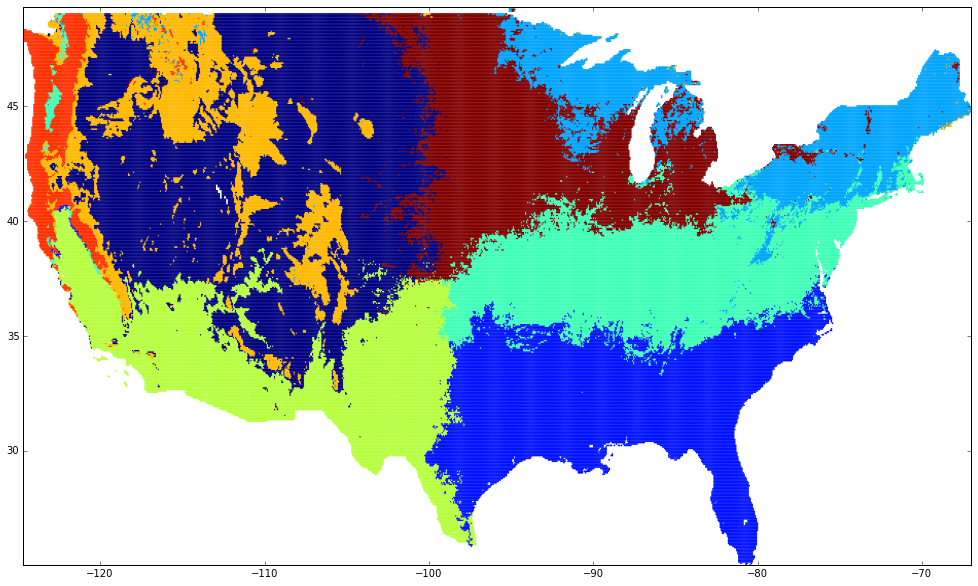

In [5]:
folder = '/home/ubuntu/dataset/'
files = ['veg.nc', 'ppt.monthly.mask.nc', 'tmean.monthly.mask.nc', 'elev.nc']
var_names = ['Cv', 'Band1', 'Band1', 'elev']

lc = Location_Clusterer(n_clusters=n)
for f, var in zip(files, var_names):
    lc.read_data(folder+f, var)

lc.transform_data()
clusters = lc.fit_predict(lc.data2d)

plot_list_in_2D(lc.coords2d[:,0], lc.coords2d[:,1], clusters)

In [7]:
# for i in xrange(n):
#     ind = (clusters==i)
#     plot_list_in_2D(lc.coords2d[:,0][ind], lc.coords2d[:,1][ind], clusters[ind])

In [8]:
%%writefile nn_input.py
# import utility libraries
from netCDF4 import Dataset
import pandas as pd
import numpy as np
from collections import OrderedDict

# import machine learning tools
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D, ZeroPadding2D, MaxPooling2D
from keras import backend as K

# import utilities and classes I wrote
from clustering import Location_Clusterer

class NN_Input(object):
    """
    Stores the input data ready for feeding into a Keras neural network. 

    To-Do:
    - add function to take the clustering data in some ways
    - add function to return the actual lat, lon, and time based on indices
    
    """
    def __init__(self, predict=2, history=2, box=5):
        """
        Initialize a class for storing neural network input data. 
        
        Parameters
        ----------
        predict: int, number of time points ahead that the model will predict. 
                 For example, if predict=2, the model will predict 2 time points away from the given time. 
        history: int, number of time points for which data would be included as input.
                 For example, if data_length=3, the model will receive 3 time points worth of data (current time
                 point, the previous time point, and the timep point before that).
        """
        self.lons = None
        self.lats = None
        self.times = None
        
        self.labels = None
        self.features = {}
        self.feature_types = {}
        self.variables = []
        
        self.predict = predict
        self.history = history
        self.box = box
        
    def load_labels(self, f_path, var):
        """
        Load labels from netCDF file. 
        
        Parameters
        ----------
        f_path: string
        var: string
        """
        nc = Dataset(f_path, 'r')
        self.lons = nc.variables['lon'][:]
        self.lats = nc.variables['lat'][:]
        
        self.times = nc.variables['time'][self.history:-self.predict]
        n = self.predict + self.history
        self.labels = nc.variables[var][n:,:,:]
        
    def load_features(self, f_path, var, name, feature_type):
        """
        Load feature values from netCDF files. Stores feature type information. 
        
        Parameters
        ----------
        f_path: string, path to input netCDF file.
        var: string, variable name as appeared in the netCDF file. 
        name: string, name of the variable to be stored. 
        feature_type: string, must be one of the following: 'history_time_series', 'forecast_time_series', 
        'multi_layers', 'single_layer'
        """
        nc = Dataset(f_path, 'r')
        temp_data = nc.variables[var][:]
        
        # Storing information on whether the input features 
        self.feature_types[name] = feature_type
        self.variables.append(name)
        
        if self.feature_types[name] == 'history_time_series':
            self.features[name] = temp_data[:-self.predict, :, :]
        elif self.feature_types[name] == 'forecast_time_series':
            self.features[name] = temp_data[self.history:, :, :]
        else:
            self.features[name] = temp_data
        
    
    def get_features(self, i, j, k):
        """
        Given indices for latitude, longitude, and time point, returns the associated data from self.data. 
        
        Parameters
        ----------
        lat: int, index for the latitude desired. Must be within the range available in self.data. 
        lon: int, index for the longitude desired. Must be within the range available in self.data. 
        time: int, index for the time point desired. Must be within the range available in self.data. 
        """
        maps = None
        lst = None
        for ix, feat in enumerate(self.variables):
            if self.feature_types[feat] == 'history_time_series':
                temp_data = self.features[feat][i:i+self.history+1, j-self.box:j+self.box+1, k-self.box:k+self.box+1]
            elif self.feature_types[feat] == 'forecast_time_series':
                temp_data = self.features[feat][i:i+self.predict+1, j-self.box:j+self.box+1, k-self.box:k+self.box+1]
            elif self.feature_types[feat] == 'multi_layers':
                temp_data = self.features[feat][:, j, k].flatten()
            else: 
                temp_data = self.features[feat][j, k]
            
            if len(temp_data.shape) == 3:                
                if np.sum(temp_data.mask) > len(temp_data.flatten())/2:
                    return None
                elif np.any(temp_data.mask):
                    temp_data = temp_data.filled(-999)
                    
                if maps is None:
                    maps = temp_data
                else:
                    maps = np.ma.concatenate((maps, temp_data), axis=0)
            else:
                if lst is None:
                    lst = temp_data
                else:
                    lst = np.append(lst, temp_data)
        return [maps, lst]
        
    def select(self, n=None, cutoff=None, subset=None):
        """
        Selecting n data points randomly from the database before specified time cutoff. 
        
        Parameters
        ----------
        n: int, number of data points wanted. 
        cutoff: int, time cutoff for the training dataset. Default is half of the data available. 
        """
        if cutoff is None:
            cutoff = len(self.times)/2
        
        indices, labels, output_maps, output_lst = [], [], [], []

        if n is None:
            for (lon, lat) in subset:
                j = np.where(self.lats==lat)[0]-1
                k = np.where(self.lons==lon)[0]-1
                for i in xrange(cutoff):
                    l = self.labels[i, j, k]
                    features = self.get_features(i, j, k)
                    if features is not None and l != np.nan and features[0].shape==output_maps[-1].shape:
                        indices.append([i, j, k])
                        labels.append(l)
                        output_maps.append(features[0])
                        output_lst.append(features[1])
        
        else:
            while len(labels) < n:
                if subset is not None: 
                    ind = np.random.choice(len(subset))
                    j = np.where(self.lats==subset[ind, 1])[0]
                    k = np.where(self.lons==subset[ind, 0])[0]
                else:
                    j = np.random.randint(self.box, len(self.lats)-self.box)
                    k = np.random.randint(self.box, len(self.lons)-self.box)

                i = np.random.randint(cutoff)
                l = self.labels[i, j, k]
                features = self.get_features(i, j, k)
                if features is not None and l != np.nan:
                    indices.append([i, j, k])
                    labels.append(l)
                    output_maps.append(features[0])
                    output_lst.append(features[1])
                    
        return indices, labels, output_maps, output_lst



Overwriting nn_input.py


In [9]:
from nn_input import NN_Input


nn = NN_Input(predict=2, history=5, box=5)
nn.load_labels(folder+'sign.label.nc', 'Band1')

# f_paths = ['all.ndvi.nc','all.max.of.Wind.nc', 'all.min.of.Tmin.nc', 'all.mean.of.Tmin.nc', 'all.sum.of.Prec.nc',
#            'all.max.of.Tmax.nc', 'all.mean.of.Tmax.nc','elev.nc', 'veg.nc']
# variables = ['Band1', 'Wind', 'Tmin', 'Tmin', 'Prec', 'Tmax', 'Tmax', 'elev', 'Cv']
# names = ['ndvi', 'max_wind', 'min_tmin', 'mean_tmin', 'total_prec', 'max_tmax', 'mean_tmax', 'elev', 'veg']
# feature_types = ['history_time_series', 'forecast_time_series', 'forecast_time_series', 'forecast_time_series',
#                  'forecast_time_series', 'forecast_time_series', 'forecast_time_series',
#                 'single_layer', 'multi_layers']

f_paths = ['all.mean.of.Tmin.nc', 'all.mean.of.Tmin.nc']
variables = ['Tmin', 'Tmin']
names = ['mean_tmin_history', 'mean_tmin_forecast']
feature_types = ['history_time_series', 'forecast_time_series']

for f_path, v, n, feature_type in zip(f_paths, variables, names, feature_types):
    nn.load_features(folder+f_path, v, n, feature_type)


In [10]:
cluster = 2

subset = lc.coords2d[clusters==cluster]
train_id, train_y, train_X_map, train_X_lst = nn.select(n=100000, subset=subset)

In [20]:
i = 100
j = 485
k = 922
a= nn.features['mean_tmin_history'][i:i+nn.history+1, j-nn.box:j+nn.box+1, k-nn.box:k+nn.box+1]
print k - nn.box
print k + nn.box + 1
print a.shape

for i, x in enumerate(train_X_map):
    if x.shape != (9,11,11):
        print 'error',i, x.shape, train_id[i]

train_X_map = np.array(train_X_map)
train_id = np.array(train_id)
train_y = np.array(train_y)


train_y[train_y == -1] = 0
train_y = np.hstack((train_y.reshape(-1,1), 1-train_y.reshape(-1,1)))

# t = (len(nn.times)/2) +1

# test_id, test_y, test_X_map, test_X_lst = [], [], [], []

# for j in xrange(nn.box, len(nn.lats)-nn.box):
#     for k in xrange(nn.box, len(nn.lons)-nn.box):
#         features =  nn.get_features(t, j, k)
#         if features is not None:
#             test_id.append([t, j, k])
#             test_y.append(nn.labels[t, j, k])
#             test_X_map.append(features[0])
#             test_X_lst.append(features[1])

# print train_X_map[0].shape
# #print train_X_lst[0].shape
# print np.array(test_X_map).shape
# print np.array(test_X_lst).shape
map_dimensions=train_X_map[0].shape
print map_dimensions
# print len(np.where(train_y==1)[0])
# print len(np.where(train_y==0)[0])
# for i, y in enumerate(train_y):
#     if y != 0 and y != 1:
#         print i, y
        
#train_X_map = train_X_map/np.max(train_X_map)
train_y.shape

917
928
(6, 11, 10)
error 25883 (9, 11, 10) [100, array([485]), array([922])]
error 25928 (9, 11, 10) [186, array([485]), array([922])]
error 32766 (9, 11, 10) [112, array([485]), array([922])]
error 73261 (9, 11, 10) [184, array([485]), array([922])]
error 97125 (9, 11, 10) [98, array([485]), array([922])]


ValueError: could not broadcast input array from shape (9,11,11) into shape (9,11)

In [ ]:
def build_base_sequential_NN(n_conv_layers=2, nb_filters=16, nb_conv=3, map_dimensions=None, nb_pool=2):

    model = Sequential()
    model.add(Convolution2D(nb_filters, nb_conv, nb_conv,
                            border_mode='valid',
                            input_shape=map_dimensions))
    
    model.add(Activation('relu'))
#     model.add(Convolution2D(nb_filters, nb_conv, nb_conv))
#     model.add(Activation('relu'))
#     model.add(MaxPooling2D(pool_size=(nb_pool, nb_pool)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(128))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2))
    model.add(Activation('softmax'))

    sgd = SGD()
    model.compile(loss='categorical_crossentropy',
                  optimizer=sgd,
                  metrics=['accuracy'])
    return model

model = build_base_sequential_NN(nb_filters=64, map_dimensions=map_dimensions)
model.fit(train_X_map, train_y, batch_size=50, nb_epoch=1, verbose=True)

In [ ]:
np.sum(train_y[:,1])

In [25]:
predict = model.predict(train_X_map[:100], verbose=True)

print predict

100/100 [==============================] - 0s     
[[  4.64530422e-05   9.99953568e-01]
 [  4.53069419e-01   5.46930552e-01]
 [  4.64530422e-05   9.99953568e-01]
 [  4.53069419e-01   5.46930552e-01]
 [  4.53069419e-01   5.46930552e-01]
 [  4.53069419e-01   5.46930552e-01]
 [  4.53069419e-01   5.46930552e-01]
 [  4.53069419e-01   5.46930552e-01]
 [  4.53069419e-01   5.46930552e-01]
 [  4.53069419e-01   5.46930552e-01]
 [  4.64530422e-05   9.99953568e-01]
 [  4.53069419e-01   5.46930552e-01]
 [  4.53069419e-01   5.46930552e-01]
 [  4.64530422e-05   9.99953568e-01]
 [  4.64530422e-05   9.99953568e-01]
 [  4.64530422e-05   9.99953568e-01]
 [  4.53069419e-01   5.46930552e-01]
 [  4.53069419e-01   5.46930552e-01]
 [  4.53069419e-01   5.46930552e-01]
 [  4.53069419e-01   5.46930552e-01]
 [  4.53069419e-01   5.46930552e-01]
 [  4.53069419e-01   5.46930552e-01]
 [  4.53069419e-01   5.46930552e-01]
 [  4.64530422e-05   9.99953568e-01]
 [  4.53069419e-01   5.46930552e-01]
 [  4.53069419e-01   5.4

In [67]:
# # graph model with two inputs and one output 
# graph = Graph() 
# graph.add_input(name='input1', input_shape=(32,)) 
# graph.add_input(name='input2', input_shape=(32,)) 
# graph.add_node(Dense(16), name='dense1', input='input1') 
# graph.add_node(Dense(4), name='dense2', input='input2') 
# graph.add_node(Dense(4), name='dense3', input='dense1') 

# graph.add_output(name='output', inputs=['dense2', 'dense3'], merge_mode='sum') 

# graph.compile(optimizer='rmsprop', loss={'output':'mse'}) 
# history = graph.fit({'input1':X_train, 'input2':X2_train, 'output':y_train}, nb_epoch=10) 
# predictions = graph.predict({'input1':X_test, 'input2':X2_test}) # {'output':...}


# graph model with two inputs and one output 
model = Graph() 

map_dimensions=train_X_map[0][0].shape

# two types of inputs: maps in 3D matrix and a list
model.add_input(name='maps', input_shape=train_X_map[0].shape) 
model.add_input(name='lst', input_shape=train_X_lst[0].shape) 

# adding layers to process the maps
# 
model.add_node(Convolution2D(64, 3, 3, activation='relu', border_mode='same', dim_ordering='th')
               , name='map_conv1', input='maps')
# add pooling layers
model.add_node(Flatten(), name='map_flatten', input='map_conv1')
model.add_node(Dense(64), name='map_dense1', input='map_flatten')

# adding layers to process the lst
model.add_node(Dense(16), name='lst_dense1', input='lst') 
model.add_node(Dense(8), name='lst_dense2', input='lst_dense1')

# merging two sets of weights
model.add_node(Dense(72, activation='relu'), name='combine', inputs=['map_flatten', 'lst_dense1'], merge_mode='concat')
model.add_node(Dense(1, activation='sigmoid'), name='reduce', input='combine')
model.add_output(name='output', input='reduce')

sgd = SGD(lr=0.001)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy']) 

# use dropouts 
# try different solver
# if acc = 0, network diverged, reduce step size

In [68]:
model.fit({'maps': train_X_map, 'lst': train_X_lst, 'output': train_y}, nb_epoch=10, batch_size=10, verbose=True)

Epoch 1/10
1000/1000 [==============================] - 45s - loss: 8.1235 - acc: 0.4960    
Epoch 2/10
1000/1000 [==============================] - 46s - loss: 8.1396 - acc: 0.4950    
Epoch 3/10
1000/1000 [==============================] - 46s - loss: 8.1396 - acc: 0.4950    
Epoch 4/10
1000/1000 [==============================] - 46s - loss: 8.1396 - acc: 0.4950    
Epoch 5/10
1000/1000 [==============================] - 46s - loss: 8.1396 - acc: 0.4950    
Epoch 6/10
1000/1000 [==============================] - 46s - loss: 8.1396 - acc: 0.4950    
Epoch 7/10
1000/1000 [==============================] - 46s - loss: 8.1396 - acc: 0.4950    
Epoch 8/10
1000/1000 [==============================] - 46s - loss: 8.1396 - acc: 0.4950    
Epoch 9/10
1000/1000 [==============================] - 86s - loss: 8.1396 - acc: 0.4950    
Epoch 10/10
1000/1000 [==============================] - 108s - loss: 8.1396 - acc: 0.4950   


In [50]:
prediction = model.predict({'maps': np.array(test_X_map), 'lst': np.array(test_X_lst)}, batch_size=1000)

KeyboardInterrupt: 

In [ ]:
prediction

In [44]:
np.array(test_X_map).shape

(11049, 22, 61, 61)

In [59]:
set(np.array(test_y))
#set(np.array(train_y))

{nan, 1.0, nan, -1.0, nan}

311